In [1]:
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [ ]:
from VR_Trajectory_analysis import *
#would be better practice:
#import VR_Trajectory_analysis as TA


In [3]:
from __future__ import annotations
import os, json, glob, re, hashlib
from pathlib import Path
from typing import Dict, Optional, Iterable
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

# ---- paths----
directory1 = '/Users/apaula/ownCloud/MatrexVR1/20250725_Gray_AngleSweep/\
20250730_GrayAngleSweep_V1_Data/RunData'
directory2 = '/Users/apaula/ownCloud/MatrexVR3/20250728_GrayAngleSweep/\
20250730_GrayAngleSweep_V1_Data/RunData'

# where to write parquet
PARQUET_ROOT = Path('/Users/apaula/ownCloud/stage_parquet_gray_angle_sweep')
PARQUET_ROOT.mkdir(parents=True, exist_ok=True)

# ---------- utilities ----------
def to_stable_trial_id(df: pd.DataFrame) -> pd.Series:
    """
    Build a deterministic trial ID from the same keys you used for grouping.
    This is stable across batches/files (unlike ngroup()).
    """
    base_cols = ['SourceFile', 'CurrentStep', 'CurrentTrial']
    if 'stepIndex' in df.columns:
        base_cols.append('stepIndex')

    # fill NA to string to keep vectorized hashing stable
    key = df[base_cols].astype('string').fillna('<NA>')
    # vectorized 64-bit hash
    return pd.util.hash_pandas_object(key, index=False).astype('uint64')

def enforce_schema(df: pd.DataFrame) -> pd.DataFrame:
    """
    Light schema enforcement. Extend this as needed.
    """
    # examples; adjust to your real columns
    cast_map = {
        'CurrentTrial': 'Int64',
        'CurrentStep': 'Int64',
        'VR': 'string',
        'stepName': 'string',
        'GameObjectPosX': 'float64',
        'GameObjectPosY': 'float64',
        'GameObjectPosZ': 'float64',
        'elapsed_time': 'float64',
        'Current Time': 'float64',  # or datetime if it truly is a timestamp
    }
    for c, dt in cast_map.items():
        if c in df.columns:
            df[c] = df[c].astype(dt, errors='ignore')
    return df

def write_parquet(df: pd.DataFrame, dest: Path):
    table = pa.Table.from_pandas(df, preserve_index=False)
    pq.write_table(
        table, dest,
        compression="zstd",           # or "snappy"
        use_dictionary=True,
        write_statistics=True
    )

def find_metadata(subdir: str) -> Optional[Dict]:
    files = glob.glob(os.path.join(subdir, '*_FlyMetaData.json'))
    if not files:
        return None
    with open(files[0], 'r') as f:
        return json.load(f)

def ingest_run_directory(run_root: str, trim_seconds: float = 1.0):
    """
    For each subfolder under run_root:
      - read *_FlyMetaData.json
      - load CSVs (those containing '_VR')
      - process -> enforce schema -> add metadata -> write to Parquet partitions
    """
    subdirectories = [
        os.path.join(run_root, d)
        for d in os.listdir(run_root)
        if os.path.isdir(os.path.join(run_root, d))
    ]
    if not subdirectories:
        print(f"No subdirectories in {run_root}")
        return

    for subdir in sorted(subdirectories):
        subfolder_name = os.path.basename(subdir)
        print(f"[ingest] subfolder: {subfolder_name}")

        meta = find_metadata(subdir)
        experimenter_name = meta.get("ExperimenterName", "") if meta else ""
        comments = meta.get("Comments", "") if meta else ""
        vr_fly_map = {}
        if meta:
            for dct in meta.get("Flies", []):
                vr = dct.get("VR")
                fly_id = dct.get("FlyID")
                if vr and fly_id:
                    vr_fly_map[vr] = str(fly_id)

        csv_paths = [
            os.path.join(subdir, f)
            for f in os.listdir(subdir)
            if f.endswith(".csv") and "_VR" in f
        ]
        if not csv_paths:
            print(f"  (no CSVs) {subfolder_name}")
            continue

        for csv_path in sorted(csv_paths):
            # You already have these helpers:
            df_loaded = load_csv(csv_path)
            df = process_dataframe(df_loaded, trim_seconds)

            if df.empty:
                print(f"  (empty) {os.path.basename(csv_path)}")
                continue

            # attach metadata
            df["ExperimenterName"] = experimenter_name
            df["Comments"] = comments
            if "VR" in df.columns:
                df["FlyID"] = df["VR"].map(vr_fly_map).astype("string")

            # stable trial id
            df["UniqueTrialID"] = to_stable_trial_id(df)

            # (optional) compute stepwise deltas here per file if every trial is confined to one SourceFile
            # else do it later when reading the full dataset
            # ---- keep your later function for correctness across files ----

            df = enforce_schema(df)

            # partition columns
            df["run"] = subfolder_name
            # normalize VR like 'VR1' -> 'vr1' (safer for folder names)
            if "VR" in df.columns:
                df["vr"] = df["VR"].astype("string").str.lower()
            else:
                df["vr"] = pd.NA
            df["flyid_part"] = df["FlyID"].fillna("unknown")

            # destination: <root>/run=<sub>/vr=<vr>/flyid=<id>/file.parquet
            # keep each csv as its own file
            safe_name = Path(csv_path).stem.replace(" ", "_")
            dest_dir = PARQUET_ROOT / f"run={subfolder_name}" / f"vr={df['vr'].dropna().iloc[0] if df['vr'].notna().any() else 'unknown'}" / f"flyid={df['flyid_part'].dropna().iloc[0]}"
            dest_dir.mkdir(parents=True, exist_ok=True)
            dest_file = dest_dir / f"{safe_name}.parquet"

            # drop the temporary partition helper col
            out_df = df.drop(columns=["flyid_part"], errors="ignore")

            write_parquet(out_df, dest_file)
            print(f"  wrote {dest_file}")

# ---- run ingestion for your two directories ----
ingest_run_directory(directory1, trim_seconds=1.0)
ingest_run_directory(directory2, trim_seconds=1.0)
print("✅ Ingestion complete.")


[ingest] subfolder: 20250730_125137
  wrote /Users/apaula/ownCloud/stage_parquet_gray_angle_sweep/run=20250730_125137/vr=vr1/flyid=k1gcmb/20250730_125137_Choice_desync_VR1_.parquet
  wrote /Users/apaula/ownCloud/stage_parquet_gray_angle_sweep/run=20250730_125137/vr=vr2/flyid=k1gcyg/20250730_125137_Choice_desync_VR2_.parquet
  wrote /Users/apaula/ownCloud/stage_parquet_gray_angle_sweep/run=20250730_125137/vr=vr3/flyid=k1gcyb/20250730_125137_Choice_desync_VR3_.parquet
  wrote /Users/apaula/ownCloud/stage_parquet_gray_angle_sweep/run=20250730_125137/vr=vr4/flyid=k1gcrg/20250730_125137_Choice_desync_VR4_.parquet
[ingest] subfolder: 20250731_112112
  wrote /Users/apaula/ownCloud/stage_parquet_gray_angle_sweep/run=20250731_112112/vr=vr1/flyid=k1kmyy/20250731_112112_Choice_desync_VR1_.parquet
  wrote /Users/apaula/ownCloud/stage_parquet_gray_angle_sweep/run=20250731_112112/vr=vr2/flyid=k1bcky/20250731_112112_Choice_desync_VR2_.parquet
  wrote /Users/apaula/ownCloud/stage_parquet_gray_angle_sw

/Users/apaula/src/VRDataAnalysis/Ants/VR_Trajectory_analysis.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elapsed_time'] = (df['Current Time'] - df['Current Time'].min()).dt.total_seconds()
/Users/apaula/src/VRDataAnalysis/Ants/VR_Trajectory_analysis.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[int_cols] = df[int_cols].apply(pd.to_numeric, errors='coerce')  # Ensure coercion


  (empty) 20250908_101031_Choice_desync_VR1_.csv
  wrote /Users/apaula/ownCloud/stage_parquet_gray_angle_sweep/run=20250908_101031/vr=vr2/flyid=k4rmky/20250908_101031_Choice_desync_VR2_.parquet
  wrote /Users/apaula/ownCloud/stage_parquet_gray_angle_sweep/run=20250908_101031/vr=vr3/flyid=k4mbmk/20250908_101031_Choice_desync_VR3_.parquet
  wrote /Users/apaula/ownCloud/stage_parquet_gray_angle_sweep/run=20250908_101031/vr=vr4/flyid=k4kmcb/20250908_101031_Choice_desync_VR4_.parquet
[ingest] subfolder: 20250908_160334
  wrote /Users/apaula/ownCloud/stage_parquet_gray_angle_sweep/run=20250908_160334/vr=vr1/flyid=k4ckmm/20250908_160334_Choice_desync_VR1_.parquet
  wrote /Users/apaula/ownCloud/stage_parquet_gray_angle_sweep/run=20250908_160334/vr=vr2/flyid=k4kmkg/20250908_160334_Choice_desync_VR2_.parquet
  wrote /Users/apaula/ownCloud/stage_parquet_gray_angle_sweep/run=20250908_160334/vr=vr3/flyid=k4rmmb/20250908_160334_Choice_desync_VR3_.parquet
  wrote /Users/apaula/ownCloud/stage_parquet_

In [4]:
import numpy as np
import pandas as pd

def add_trial_id_and_displacement(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return df

    # Use the stable ID we wrote (if not present, compute it now)
    if "UniqueTrialID" not in df.columns:
        df["UniqueTrialID"] = to_stable_trial_id(df)

    # Sort within trial
    df = df.sort_values(by=['UniqueTrialID', 'Current Time'], kind='mergesort')

    # Stepwise displacement
    for axis, col in zip(['x','y','z'], ['GameObjectPosX','GameObjectPosY','GameObjectPosZ']):
        if col in df.columns:
            df[f'delta_{axis}'] = df.groupby('UniqueTrialID')[col].diff()
        else:
            df[f'delta_{axis}'] = np.nan

    df['step_distance'] = np.sqrt(
        df['delta_x'].fillna(0)**2 + df['delta_y'].fillna(0)**2 + df['delta_z'].fillna(0)**2
    )

    # Ensure chronological order for path calculations
    if 'elapsed_time' in df.columns:
        df = df.sort_values(['UniqueTrialID', 'elapsed_time'], kind='mergesort')

    # Displacement & travel direction in Unity yaw convention
    disp_dir = (
        df.groupby('UniqueTrialID')
          .agg(first_x=('GameObjectPosX','first'),
               last_x =('GameObjectPosX','last'),
               first_z=('GameObjectPosZ','first'),
               last_z =('GameObjectPosZ','last'))
          .assign(
              TotalDisplacement=lambda g: np.hypot(g['last_x']-g['first_x'], g['last_z']-g['first_z']),
              TravelDirectionDeg=lambda g: (np.degrees(np.arctan2(g['last_x']-g['first_x'],
                                                                  g['last_z']-g['first_z'])) + 360) % 360
          )
          .reset_index()[['UniqueTrialID','TotalDisplacement','TravelDirectionDeg']]
    )

    path_length = (
        df.groupby('UniqueTrialID')['step_distance'].sum()
          .reset_index().rename(columns={'step_distance':'TotalPathLength'})
    )

    df = df.merge(disp_dir, on='UniqueTrialID', how='left')
    df = df.merge(path_length, on='UniqueTrialID', how='left')
    return df

def classify_trials_by_displacement(df: pd.DataFrame, min_disp=0, max_disp=50):
    if df.empty: return df, df, df, [], [], []
    total_displacement = df.groupby('UniqueTrialID')['TotalDisplacement'].first().reset_index()
    stationary_trial_ids = total_displacement[total_displacement['TotalDisplacement'] < min_disp]['UniqueTrialID'].unique()
    normal_trial_ids = total_displacement[
        (total_displacement['TotalDisplacement'] >= min_disp) &
        (total_displacement['TotalDisplacement'] <= max_disp)
    ]['UniqueTrialID'].unique()
    excessive_trial_ids = total_displacement[total_displacement['TotalDisplacement'] > max_disp]['UniqueTrialID'].unique()

    return (
        df[df['UniqueTrialID'].isin(stationary_trial_ids)].reset_index(drop=True),
        df[df['UniqueTrialID'].isin(normal_trial_ids)].reset_index(drop=True),
        df[df['UniqueTrialID'].isin(excessive_trial_ids)].reset_index(drop=True),
        stationary_trial_ids, normal_trial_ids, excessive_trial_ids
    )

def classify_trials_by_path_length(df: pd.DataFrame, min_length=0, max_length=50):
    if df.empty: return df, df, df, [], [], []
    total_path_length = df.groupby('UniqueTrialID')['TotalPathLength'].first().reset_index()
    stationary_trial_ids = total_path_length[total_path_length['TotalPathLength'] < min_length]['UniqueTrialID'].unique()
    normal_trial_ids = total_path_length[
        (total_path_length['TotalPathLength'] >= min_length) &
        (total_path_length['TotalPathLength'] <= max_length)
    ]['UniqueTrialID'].unique()
    excessive_trial_ids = total_path_length[total_path_length['TotalPathLength'] > max_length]['UniqueTrialID'].unique()

    return (
        df[df['UniqueTrialID'].isin(stationary_trial_ids)].reset_index(drop=True),
        df[df['UniqueTrialID'].isin(normal_trial_ids)].reset_index(drop=True),
        df[df['UniqueTrialID'].isin(excessive_trial_ids)].reset_index(drop=True),
        stationary_trial_ids, normal_trial_ids, excessive_trial_ids
    )


In [ ]:
# --- Imports ---
from pathlib import Path
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.dataset as ds
import pyarrow.parquet as pq

# --- Paths ---
PARQUET_ROOT = Path('/Users/apaula/ownCloud/stage_parquet_gray_angle_sweep')
SNAP_ROOT = PARQUET_ROOT / "_snapshots"
SNAP_ROOT.mkdir(exist_ok=True)

# --- Choose only the columns needed for your analysis ---
CORE_COLS = [
    "SourceFile", "CurrentStep", "CurrentTrial", "stepIndex",
    "VR", "FlyID", "stepName",
    "GameObjectPosX", "GameObjectPosY", "GameObjectPosZ",
    "elapsed_time", "Current Time",
    "UniqueTrialID",
    "run", "vr",  # partitions if present
]

def _cast_table_strings_to_large(table: pa.Table, only_cols=None) -> pa.Table:
    """
    Return a new table where Arrow 'string' columns are upgraded to 'large_string'.
    (Works on older pyarrow that can't pass schema= to dataset.to_table.)
    """
    fields = []
    for f in table.schema:
        if (only_cols is None or f.name in only_cols) and pa.types.is_string(f.type):
            fields.append(pa.field(f.name, pa.large_string()))
        else:
            fields.append(f)
    target = pa.schema(fields)
    # pa.Table.cast is available broadly; safe cast string->large_string
    return table.cast(target)  # safe=True by default

def load_dataset_subset_as_pandas(root: Path, wanted_cols=None,
                                  cat_cols=None, cat_threshold=20000) -> pd.DataFrame:
    """
    - Reads a partitioned Parquet dataset (Hive).
    - Selects only wanted columns present.
    - Upgrades Arrow string -> large_string to avoid overflow.
    - Converts selected columns to pandas Categorical when cardinality is reasonable.
    """
    dataset = ds.dataset(str(root), format="parquet", partitioning="hive")

    # Intersect requested columns with what's actually there
    if wanted_cols is None:
        cols = dataset.schema.names
    else:
        cols = [c for c in wanted_cols if c in dataset.schema.names]

    # 1) read to Arrow table (no schema arg)
    table = dataset.to_table(columns=cols)

    # 2) upgrade strings to large_string
    table = _cast_table_strings_to_large(table, only_cols=cols)w

    # 3) convert to pandas (Arrow-backed)
    df = table.to_pandas(types_mapper=pd.ArrowDtype)

    # 4) ensure 'Current Time' is datetime[ns, tz] (if present)
    if "Current Time" in df.columns and not pd.api.types.is_datetime64_any_dtype(df["Current Time"]):
        df["Current Time"] = pd.to_datetime(df["Current Time"], errors="coerce", utc=True)

    # 5) convert chosen text columns to category (memory win)
    if cat_cols is None:
        cat_cols = ["VR", "vr", "FlyID", "stepName", "run"]
    for c in cat_cols:
        if c in df.columns:
            s = df[c].astype("string[python]")   # normalize first
            nunique = s.nunique(dropna=True)
            df[c] = s.astype("category") if nunique <= cat_threshold else s

    return df

# --- Load a slim dataframe for the analysis ---
df_all = load_dataset_subset_as_pandas(
    PARQUET_ROOT,
    wanted_cols=CORE_COLS,
    cat_cols=["VR", "vr", "FlyID", "stepName", "run"],
    cat_threshold=20000,
)

# --- Your existing analysis ---
# Ensure UniqueTrialID exists (ingest wrote it; compute if missing)
if "UniqueTrialID" not in df_all.columns:
    df_all["UniqueTrialID"] = to_stable_trial_id(df_all)

df_all = add_trial_id_and_displacement(df_all)

# Filter out skybox and tiny displacements
stepname = df_all["stepName"] if "stepName" in df_all.columns else pd.Series(True, index=df_all.index)
mask = (stepname != 'skybox') & (df_all['TotalDisplacement'].gt(12))
df_filtered = df_all.loc[mask].copy()

df_stationary, df_normal, df_excessive, *_ = classify_trials_by_path_length(
    df_filtered, min_length=0, max_length=100
)

# Add angle + shades to df_normal
if "stepName" in df_normal.columns:
    step_str = df_normal["stepName"].astype("string[python]")
    df_normal["Angle"] = step_str.apply(lambda x: parse_angle_from_config(x, default_angle=999.0))
    df_normal[["shade1", "shade2", "conflict_angle"]] = (
        step_str.str.extract(r'_(\d{2})_(\d{2})_(\d{2,3})deg$').astype(float)
    )
else:
    df_normal["Angle"] = np.nan
    df_normal[["shade1", "shade2", "conflict_angle"]] = np.nan

# Summarise one row per trial
trial_summary = (
    df_normal.sort_values(['UniqueTrialID', 'elapsed_time'], kind='mergesort')
             .groupby('UniqueTrialID', observed=True)
             .agg(
                 FlyID=('FlyID', 'first'),
                 angle=('Angle', 'first'),
                 travel_dir=('TravelDirectionDeg', 'first'),
                 shade1=('shade1', 'first'),
                 shade2=('shade2', 'first'),
             )
             .dropna(subset=['angle', 'travel_dir'])
             .reset_index()
)
trial_summary['travel_dir_signed'] = ((trial_summary['travel_dir'] + 180) % 360) - 180

# --- Save snapshots ---
pq.write_table(pa.Table.from_pandas(df_normal.reset_index(drop=True), preserve_index=False),
               SNAP_ROOT / "df_normal.parquet", compression="zstd")
pq.write_table(pa.Table.from_pandas(trial_summary.reset_index(drop=True), preserve_index=False),
               SNAP_ROOT / "trial_summary.parquet", compression="zstd")

print("💾 Saved df_normal & trial_summary snapshots.")


💾 Saved df_normal & trial_summary snapshots.


In [3]:
from pathlib import Path
import pandas as pd

PARQUET_ROOT = Path('/Users/apaula/ownCloud/stage_parquet_gray_angle_sweep')
SNAP_ROOT = PARQUET_ROOT / "_snapshots"

# Load the trial summary snapshot
trial_summary = pd.read_parquet(SNAP_ROOT / "trial_summary.parquet", engine="pyarrow")

# Or load df_normal if you need it
df_normal = pd.read_parquet(SNAP_ROOT / "df_normal.parquet", engine="pyarrow")

print(trial_summary.head())


      UniqueTrialID   FlyID  angle  travel_dir  shade1  shade2  \
0   178383508214326  k1wcgm   10.0  344.881249    40.0     0.0   
1   397010905431427  k1kmyy   60.0  357.642505    40.0     0.0   
2  3409479586643187  k4kmym   90.0   16.073659     0.0    40.0   
3  3619453126220546  k4kmyy   70.0    4.820989    40.0     0.0   
4  4850677815990540  k4rmyg  100.0  308.504596    40.0     0.0   

   travel_dir_signed  
0         -15.118751  
1          -2.357495  
2          16.073659  
3           4.820989  
4         -51.495404  


In [3]:
if RUN_Data_Load_CELLS:
    directory1 = '/Users/apaula/ownCloud/MatrexVR1/20250725_Gray_AngleSweep/20250730_GrayAngleSweep_V1_Data/RunData'
    directory2 = '/Users/apaula/ownCloud/MatrexVR3/20250728_GrayAngleSweep/20250730_GrayAngleSweep_V1_Data/RunData'

In [4]:
if RUN_Data_Load_CELLS:
    df1 = get_combined_df(directory1, trim_seconds=1.0)
    df2 = get_combined_df(directory2, trim_seconds=1.0)

    concat_df = pd.concat([df1, df2], ignore_index=True)

In [5]:
if RUN_Data_Load_CELLS:
    concat_df = add_trial_id_and_displacement(df1)
    concat_df = add_trial_time(df1)

In [6]:
if RUN_Data_Load_CELLS:
    concat_df_path_pickle = '/Users/apaula/src/VRDataAnalysis/Ants/preprocessed_data/staticDecisions/GreyAngleSweep_40_concat_df1.pkl'
    concat_df.to_pickle(concat_df_path_pickle)

In [7]:
if not RUN_Data_Load_CELLS and Run_Data_Preprocess_CELLS:
    concat_df_path_pickle = '/Users/apaula/src/VRDataAnalysis/Ants/preprocessed_data/staticDecisions/GreyAngleSweep_40_concat_df1.pkl'
    concat_df = pd.read_pickle(concat_df_path_pickle)

In [8]:
if Run_Data_Preprocess_CELLS:
    df_stationary, df_normal, df_excessive, stationary_ids, normal_ids, excessive_ids = classify_trials_by_path_length(concat_df[(concat_df['stepName'] != 'skybox') & (concat_df['TotalDisplacement'].gt(12))], min_length=0, max_length=100)
    #add angle column to df_joined
    
    df_normal['Angle'] = df_normal['stepName'].apply(lambda x: parse_angle_from_config(x, default_angle=999.0))

In [9]:
if Run_Data_Preprocess_CELLS:

    df_normal[['shade1', 'shade2', 'conflict_angle']] = (
        df_normal['stepName']
        .str.extract(r'_(\d{2})_(\d{2})_(\d{2,3})deg$')
        .astype(float)   # or int if you’re sure all match
    )



    # -------- 1. summarise to one row per trial -------------------------------
    trial_summary = (
        df_normal
        .sort_values(['UniqueTrialID', 'elapsed_time'])
        .groupby('UniqueTrialID')
        .agg(
            FlyID=('FlyID', 'first'),  # or 'unique' if needed
            angle=('Angle', 'first'),
            travel_dir=('TravelDirectionDeg', 'first'),
            shade1=('shade1', 'first'),
            shade2=('shade2', 'first'),
        )
        .dropna(subset=['angle', 'travel_dir'])
        .reset_index()
    )

    # convert Unity heading (0–360) → signed heading (-180…+180)  ⟹  0 in the middle
    trial_summary['travel_dir_signed'] = (
        (trial_summary['travel_dir'] + 180) % 360    # shift, wrap into 0-360
        - 180                                        # back to signed range
    )

In [10]:
if Run_Data_Preprocess_CELLS:
    trial_summary_df_path_pickle = '/Users/apaula/src/VRDataAnalysis/Ants/preprocessed_data/staticDecisions/GreyAngleSweep_40_trial_summary_df1.pkl'
    trial_summary.to_pickle(trial_summary_df_path_pickle)

In [12]:
if Run_Data_Preprocess_CELLS is False:
    trial_summary_df_path_pickle = '/Users/apaula/src/VRDataAnalysis/Ants/preprocessed_data/staticDecisions/GreyAngleSweep_trial_summary.pkl'
    trial_summary = pd.read_pickle(trial_summary_df_path_pickle)

In [4]:

# --- Select and prepare Group A (mirror travel direction) ---
group_a = trial_summary[
    (trial_summary['shade1'] == 0) &
    (trial_summary['shade2'] == 40)
].copy()
group_a['travel_dir_signed'] = -group_a['travel_dir_signed']
group_a['group'] = 'mirror (shade1=40, shade2=0)'

# --- Group B (no mirroring) ---
group_b = trial_summary[
    (trial_summary['shade1'] == 40) &
    (trial_summary['shade2'] == 0)
].copy()
group_b['group'] = 'original (shade1=0, shade2=40)'

# --- Combine mirrored + original ---
group_ab = pd.concat([group_a, group_b], ignore_index=True)

In [5]:

# --- Select and prepare Group A (mirror travel direction) ---
group_a = trial_summary[
    (trial_summary['shade1'] == 0) &
    (trial_summary['shade2'] == 40)
].copy()
group_a['travel_dir_signed'] = -group_a['travel_dir_signed']
group_a['group'] = 'mirror (shade1=40, shade2=0)'

# --- Group B (no mirroring) ---
group_b = trial_summary[
    (trial_summary['shade1'] == 40) &
    (trial_summary['shade2'] == 0)
].copy()
group_b['group'] = 'original (shade1=0, shade2=40)'

# --- Combine mirrored + original ---
group_ab = pd.concat([group_a, group_b], ignore_index=True)

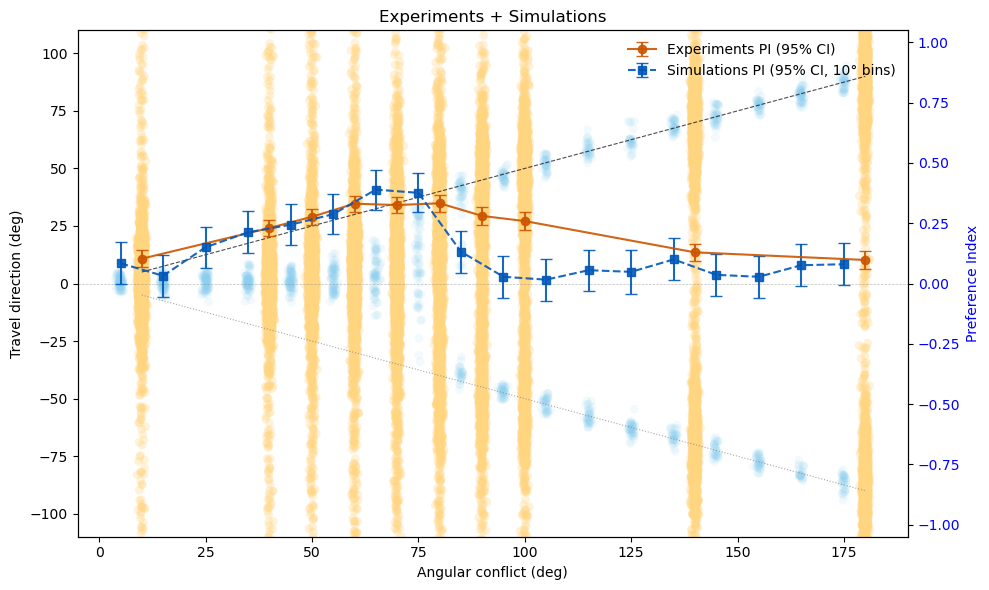

In [6]:
# --- COMBINED PLOT: Experiments (exact angles) + Simulations (10° bins) with distinct colors ---
import os, json, h5py
import numpy as np
import matplotlib.pyplot as plt

# ==== CONFIG ====
sim_data_folder = "/Users/apaula/src/SimulationResults/20250811_183013_sweep_angles_symmetric_kappa_10_10_strength_0.9_1.0_prerun"
sim_h5_path = os.path.join(sim_data_folder, "experiment.h5")
angle_bin_deg = 10  # for simulations
snap_tol_deg = 0.75  # tolerance for snapping sim angles to nearest bin center for scatter display

# Colors: (bright points, dark line)
sim_point_color = "#89CFF0"  # bright blue
sim_line_color  = "#0057B8"  # dark blue
exp_point_color = "#FFD580"  # bright orange
exp_line_color  = "#CC5500"  # dark orange

# ---------- Helpers ----------
def compute_pi(vals):
    vals = np.asarray(vals, dtype=float)
    n_pos = np.sum(vals > 0)
    n_neg = np.sum(vals < 0)
    total = n_pos + n_neg
    if total > 0:
        p = n_pos / total
        pi = 2*p - 1
        se_p = np.sqrt(p * (1 - p) / total)
        ci95 = 1.96 * (2 * se_p)
    else:
        pi, ci95 = np.nan, np.nan
    return pi, ci95

def _read_ds(g, name):
    if name not in g:
        return None
    ds = g[name]
    enc = ds.attrs.get("encoding", None)
    if enc == b"json-utf8" or enc == "json-utf8":
        payload = bytes(ds[:].tolist())
        return np.array(json.loads(payload.decode("utf-8")))
    return ds[:]

# ---------- Load simulations (into degrees) ----------
angles_to_finaldirs_deg = {}
with h5py.File(sim_h5_path, "r") as f:
    runs = f["runs"]
    for run_name in runs:
        g = runs[run_name]
        angle_attr = float(g.attrs["angle"])
        avg_dir = _read_ds(g, "average_direction")
        if avg_dir is None or len(avg_dir) == 0:
            continue
        if abs(angle_attr) <= np.pi and np.nanmax(np.abs(avg_dir)) <= np.pi + 1e-6:
            angle_deg = float(np.degrees(angle_attr))
            final_direction_deg = float(np.degrees(np.array(avg_dir, dtype=float)[-1]))
        else:
            angle_deg = float(angle_attr)
            final_direction_deg = float(np.array(avg_dir, dtype=float)[-1])
        angles_to_finaldirs_deg.setdefault(angle_deg, []).append(final_direction_deg)

# ---------- PI for experiments (exact angles) ----------
exp_angles_deg = sorted(group_ab['angle'].unique())
exp_centers, exp_pi, exp_ci95 = [], [], []
for a in exp_angles_deg:
    vals = group_ab.loc[group_ab['angle'] == a, 'travel_dir_signed'].values
    pi, ci = compute_pi(vals)
    exp_centers.append(a); exp_pi.append(pi); exp_ci95.append(ci)
exp_centers = np.array(exp_centers)
exp_pi = np.array(exp_pi)
exp_ci95 = np.array(exp_ci95)

# ---------- PI for simulations (10° bins) ----------
angle_min = max(0, np.floor(min(angles_to_finaldirs_deg.keys())))
angle_max = min(180, np.ceil(max(angles_to_finaldirs_deg.keys())))
edges = np.arange(angle_min, angle_max + angle_bin_deg, angle_bin_deg)
sim_bin_centers = 0.5 * (edges[:-1] + edges[1:])
sim_pi = []
sim_ci95 = []
for lo, hi in zip(edges[:-1], edges[1:]):
    bin_vals = []
    for angle_val, dirs in angles_to_finaldirs_deg.items():
        if lo <= angle_val < hi:
            bin_vals.extend(dirs)
    pi, ci = compute_pi(bin_vals)
    sim_pi.append(pi)
    sim_ci95.append(ci)
sim_pi = np.array(sim_pi)
sim_ci95 = np.array(sim_ci95)

# ---------- Combined plot ----------
rng = np.random.default_rng(42)
def jitter(x, scale=0.4):
    return x + rng.normal(0, scale, size=len(x))

fig, ax1 = plt.subplots(figsize=(10, 6))

# Scatter experiments (bright blue)
ax1.scatter(jitter(group_ab['angle'].values), group_ab['travel_dir_signed'].values,
            s=40, alpha=0.3, color=exp_point_color, edgecolors='none')

# Scatter simulations (bright orange)
sim_angles_all, sim_dirs_all = [], []
bin_centers_arr = np.array(sim_bin_centers)
for a, vals in angles_to_finaldirs_deg.items():
    nearest_bin = bin_centers_arr[np.argmin(np.abs(bin_centers_arr - a))]
    if abs(nearest_bin - a) <= snap_tol_deg:
        sim_angles_all.extend([nearest_bin]*len(vals))
        sim_dirs_all.extend(vals)
if sim_angles_all:
    ax1.scatter(jitter(np.array(sim_angles_all)), np.array(sim_dirs_all),
                s=40, alpha=0.1, color=sim_point_color, edgecolors='none')

# Reference lines
x_line = np.linspace(min(exp_angles_deg), max(exp_angles_deg), 160)
ax1.plot(x_line,  0.5 * x_line, ls='--', c='black', lw=0.8, alpha=0.7)
ax1.plot(x_line, -0.5 * x_line, ls=':',  c='grey',  lw=0.8, alpha=0.7)
ax1.axhline(0, color='grey', ls='--', lw=0.5, alpha=0.5)

# PI overlays (dark versions)
ax2 = ax1.twinx()
ax2.errorbar(
    exp_centers, exp_pi, yerr=exp_ci95,
    fmt='o-', capsize=4, alpha=0.9, color=exp_line_color,
    label='Experiments PI (95% CI)'
)
ax2.errorbar(
    sim_bin_centers, sim_pi, yerr=sim_ci95,
    fmt='s--', capsize=4, alpha=0.9, color=sim_line_color,
    label=f'Simulations PI (95% CI, {angle_bin_deg}° bins)'
)

# Labels, limits, title
ax1.set_xlabel("Angular conflict (deg)")
ax1.set_ylabel("Travel direction (deg)", color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(-110, 110)
ax2.set_ylabel('Preference Index', color='blue')
ax2.set_ylim(-1.05, 1.05)
ax2.tick_params(axis='y', labelcolor='blue')
plt.title('Experiments + Simulations')

# Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', frameon=False)

fig.tight_layout()
plt.show()


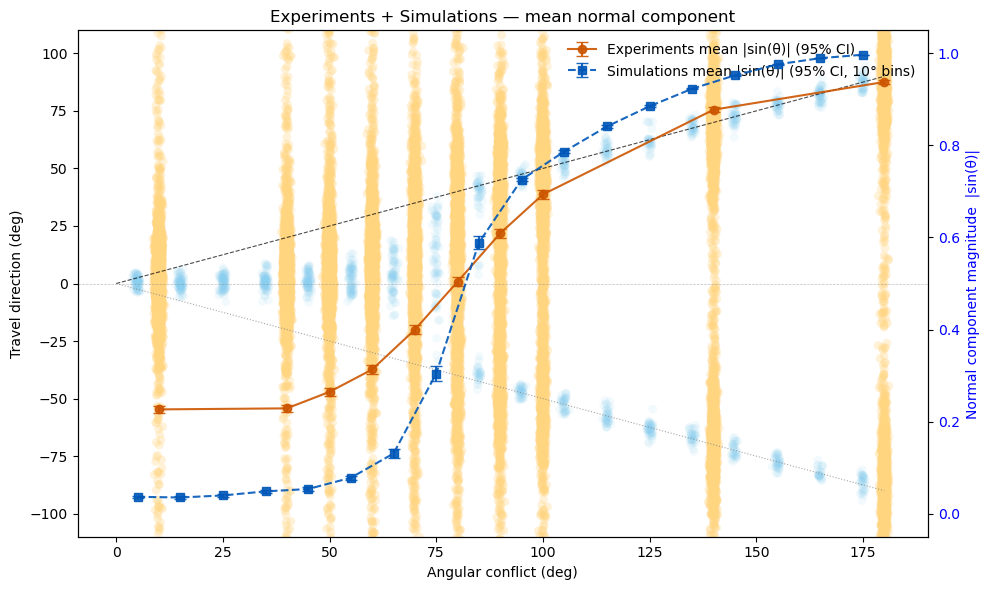

In [7]:
# --- COMBINED PLOT: Experiments (exact angles) + Simulations (10° bins)
# --- Order parameter: mean |sin(direction)| (unitless, 0..1) ---
import os, json, h5py
import numpy as np
import matplotlib.pyplot as plt

# ==== CONFIG ====
sim_data_folder = "/Users/apaula/src/SimulationResults/20250811_183013_sweep_angles_symmetric_kappa_10_10_strength_0.9_1.0_prerun"
sim_h5_path = os.path.join(sim_data_folder, "experiment.h5")
angle_bin_deg = 10    # for simulations
snap_tol_deg = 0.75   # tolerance for snapping sim angles to nearest bin center for scatter display

# Colors: (bright points, dark line)
sim_point_color = "#89CFF0"  # bright blue
sim_line_color  = "#0057B8"  # dark blue
exp_point_color = "#FFD580"  # bright orange
exp_line_color  = "#CC5500"  # dark orange

# ---------- Helpers ----------
def mean_ci95(vals):
    """Return (mean, 95% CI half-width) for finite vals using normal approx.
       If n<2 => CI is nan."""
    x = np.asarray(vals, dtype=float)
    x = x[np.isfinite(x)]
    n = x.size
    if n == 0:
        return np.nan, np.nan
    m = np.mean(x)
    if n < 2:
        return m, np.nan
    s = np.std(x, ddof=1)
    ci = 1.96 * s / np.sqrt(n)
    # order parameter is in [0, 1]; clip to stay in-range visually
    return m, np.clip(ci, 0.0, 1.0)

def normal_component_magnitude_deg(direction_deg_array):
    """Compute |sin(theta)| where theta is in degrees."""
    theta_rad = np.radians(direction_deg_array.astype(float))
    return np.abs(np.sin(theta_rad))

def _read_ds(g, name):
    if name not in g:
        return None
    ds = g[name]
    enc = ds.attrs.get("encoding", None)
    if enc == b"json-utf8" or enc == "json-utf8":
        payload = bytes(ds[:].tolist())
        return np.array(json.loads(payload.decode("utf-8")))
    return ds[:]

# ---------- Load simulations (into degrees) ----------
angles_to_finaldirs_deg = {}
with h5py.File(sim_h5_path, "r") as f:
    runs = f["runs"]
    for run_name in runs:
        g = runs[run_name]
        angle_attr = float(g.attrs["angle"])
        avg_dir = _read_ds(g, "average_direction")
        if avg_dir is None or len(avg_dir) == 0:
            continue
        # detect radians vs degrees
        if abs(angle_attr) <= np.pi and np.nanmax(np.abs(avg_dir)) <= np.pi + 1e-6:
            angle_deg = float(np.degrees(angle_attr))
            final_direction_deg = float(np.degrees(np.array(avg_dir, dtype=float)[-1]))
        else:
            angle_deg = float(angle_attr)
            final_direction_deg = float(np.array(avg_dir, dtype=float)[-1])
        angles_to_finaldirs_deg.setdefault(angle_deg, []).append(final_direction_deg)

# ---------- Order parameter for experiments (exact angles) ----------
# expects: group_ab with columns ['angle', 'travel_dir_signed'] in degrees
exp_angles_deg = sorted(group_ab['angle'].unique())
exp_centers, exp_mean_nc, exp_ci95 = [], [], []
for a in exp_angles_deg:
    dirs_deg = group_ab.loc[group_ab['angle'] == a, 'travel_dir_signed'].values
    nc = normal_component_magnitude_deg(dirs_deg)
    m, ci = mean_ci95(nc)
    exp_centers.append(a); exp_mean_nc.append(m); exp_ci95.append(ci)
exp_centers = np.array(exp_centers)
exp_mean_nc = np.array(exp_mean_nc)
exp_ci95 = np.array(exp_ci95)

# ---------- Order parameter for simulations (10° bins) ----------
if len(angles_to_finaldirs_deg) == 0:
    raise ValueError("No simulation runs loaded; check sim_h5_path.")

angle_min = max(0, np.floor(min(angles_to_finaldirs_deg.keys())))
angle_max = min(180, np.ceil(max(angles_to_finaldirs_deg.keys())))
edges = np.arange(angle_min, angle_max + angle_bin_deg, angle_bin_deg)
sim_bin_centers = 0.5 * (edges[:-1] + edges[1:])
sim_mean_nc, sim_ci95 = [], []
for lo, hi in zip(edges[:-1], edges[1:]):
    bin_dirs = []
    for angle_val, dirs in angles_to_finaldirs_deg.items():
        if lo <= angle_val < hi:
            bin_dirs.extend(dirs)
    bin_dirs = np.array(bin_dirs, dtype=float)
    nc = normal_component_magnitude_deg(bin_dirs)
    m, ci = mean_ci95(nc)
    sim_mean_nc.append(m)
    sim_ci95.append(ci)
sim_mean_nc = np.array(sim_mean_nc)
sim_ci95 = np.array(sim_ci95)

# ---------- Combined plot ----------
rng = np.random.default_rng(42)
def jitter(x, scale=0.4):
    return x + rng.normal(0, scale, size=len(x))

fig, ax1 = plt.subplots(figsize=(10, 6))

# Scatter experiments (raw directions, bright orange)
ax1.scatter(jitter(group_ab['angle'].values), group_ab['travel_dir_signed'].values,
            s=40, alpha=0.3, color=exp_point_color, edgecolors='none')

# Scatter simulations (raw directions, bright blue), snapped to nearest bin center for display
sim_angles_all, sim_dirs_all = [], []
bin_centers_arr = np.array(sim_bin_centers)
for a, vals in angles_to_finaldirs_deg.items():
    nearest_bin = bin_centers_arr[np.argmin(np.abs(bin_centers_arr - a))]
    if abs(nearest_bin - a) <= snap_tol_deg:
        sim_angles_all.extend([nearest_bin] * len(vals))
        sim_dirs_all.extend(vals)
if sim_angles_all:
    ax1.scatter(jitter(np.array(sim_angles_all)), np.array(sim_dirs_all),
                s=40, alpha=0.1, color=sim_point_color, edgecolors='none')

# Reference lines on direction axis
x_line_min = min(min(exp_angles_deg), edges[0])
x_line_max = max(max(exp_angles_deg), edges[-1])
x_line = np.linspace(x_line_min, x_line_max, 200)
ax1.plot(x_line,  0.5 * x_line, ls='--', c='black', lw=0.8, alpha=0.7)
ax1.plot(x_line, -0.5 * x_line, ls=':',  c='grey',  lw=0.8, alpha=0.7)
ax1.axhline(0, color='grey', ls='--', lw=0.5, alpha=0.5)

# Order parameter overlays (right y-axis)
ax2 = ax1.twinx()
ax2.errorbar(
    exp_centers, exp_mean_nc, yerr=exp_ci95,
    fmt='o-', capsize=4, alpha=0.9, color=exp_line_color,
    label='Experiments mean |sin(θ)| (95% CI)'
)
ax2.errorbar(
    sim_bin_centers, sim_mean_nc, yerr=sim_ci95,
    fmt='s--', capsize=4, alpha=0.9, color=sim_line_color,
    label=f'Simulations mean |sin(θ)| (95% CI, {angle_bin_deg}° bins)'
)

# Labels, limits, title
ax1.set_xlabel("Angular conflict (deg)")
ax1.set_ylabel("Travel direction (deg)", color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(-110, 110)

ax2.set_ylabel('Normal component magnitude  |sin(θ)|', color='blue')
ax2.set_ylim(-0.05, 1.05)
ax2.tick_params(axis='y', labelcolor='blue')

plt.title('Experiments + Simulations — mean normal component')

# Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', frameon=False)

fig.tight_layout()
plt.show()


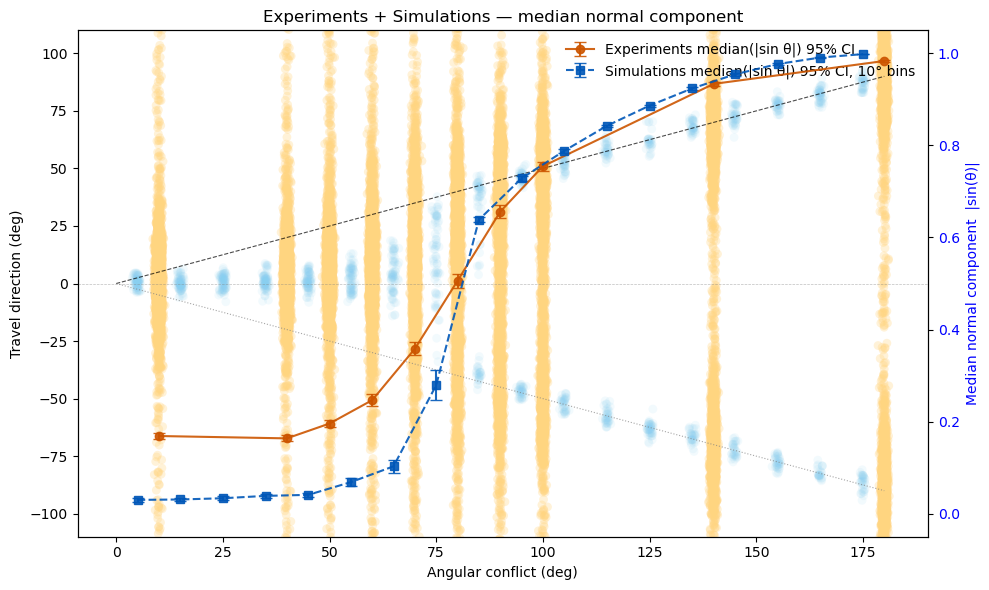

In [8]:
# --- COMBINED PLOT: Experiments (exact angles) + Simulations (10° bins)
# --- Order parameter: median/mode of |sin(direction)| with 95% bootstrap CI ---
import os, json, h5py
import numpy as np
import matplotlib.pyplot as plt

# ==== CONFIG ====
sim_data_folder = "/Users/apaula/src/SimulationResults/20250811_183013_sweep_angles_symmetric_kappa_10_10_strength_0.9_1.0_prerun"
sim_h5_path = os.path.join(sim_data_folder, "experiment.h5")
angle_bin_deg = 10    # for simulations
snap_tol_deg = 0.75   # tolerance for snapping sim angles to nearest bin center for scatter display
ORDER_STAT = "median" # choose: "median" or "mode"
N_BOOT = 1000         # bootstrap samples for CI

# Colors: (bright points, dark line)
sim_point_color = "#89CFF0"  # bright blue
sim_line_color  = "#0057B8"  # dark blue
exp_point_color = "#FFD580"  # bright orange
exp_line_color  = "#CC5500"  # dark orange

# ---------- Helpers ----------
def _read_ds(g, name):
    if name not in g:
        return None
    ds = g[name]
    enc = ds.attrs.get("encoding", None)
    if enc == b"json-utf8" or enc == "json-utf8":
        payload = bytes(ds[:].tolist())
        return np.array(json.loads(payload.decode("utf-8")))
    return ds[:]

def normal_component_magnitude_deg(direction_deg_array):
    """Compute |sin(theta)| where theta is in degrees (returns in [0,1])."""
    theta_rad = np.radians(direction_deg_array.astype(float))
    return np.abs(np.sin(theta_rad))

def _mode_hist(x, bins="fd"):
    """Histogram-mode estimator: return bin center of the highest-density bin."""
    if isinstance(bins, str) and bins == "fd":
        # Freedman–Diaconis; fallback to 10 bins if degenerate
        q25, q75 = np.percentile(x, [25, 75])
        iqr = q75 - q25
        h = 2 * iqr * (len(x) ** (-1/3)) if iqr > 0 else 0
        if h > 0:
            bins = max(5, int(np.ceil((x.max() - x.min()) / h)))
        else:
            bins = 10
    counts, edges = np.histogram(x, bins=bins, range=(0.0, 1.0))
    k = np.argmax(counts)
    return 0.5 * (edges[k] + edges[k+1])

def order_stat_with_ci(x, stat="median", n_boot=1000, rng_seed=0):
    """Return (estimate, ci_halfwidth) for stat in {'median','mode'} using bootstrap 95% CI."""
    x = np.asarray(x, float)
    x = x[np.isfinite(x)]
    n = x.size
    if n == 0:
        return np.nan, np.nan
    if stat == "median":
        est = np.median(x)
        if n < 2:
            return est, np.nan
        rng = np.random.default_rng(rng_seed)
        boots = []
        for _ in range(n_boot):
            sample = rng.choice(x, size=n, replace=True)
            boots.append(np.median(sample))
        lo, hi = np.percentile(boots, [2.5, 97.5])
    elif stat == "mode":
        est = _mode_hist(x)
        if n < 3:
            return est, np.nan
        rng = np.random.default_rng(rng_seed)
        boots = []
        for _ in range(n_boot):
            sample = rng.choice(x, size=n, replace=True)
            boots.append(_mode_hist(sample))
        lo, hi = np.percentile(boots, [2.5, 97.5])
    else:
        raise ValueError("stat must be 'median' or 'mode'")
    ci_half = 0.5 * (hi - lo)
    return float(est), float(ci_half)

# ---------- Load simulations (into degrees) ----------
angles_to_finaldirs_deg = {}
with h5py.File(sim_h5_path, "r") as f:
    runs = f["runs"]
    for run_name in runs:
        g = runs[run_name]
        angle_attr = float(g.attrs["angle"])
        avg_dir = _read_ds(g, "average_direction")
        if avg_dir is None or len(avg_dir) == 0:
            continue
        # detect radians vs degrees
        if abs(angle_attr) <= np.pi and np.nanmax(np.abs(avg_dir)) <= np.pi + 1e-6:
            angle_deg = float(np.degrees(angle_attr))
            final_direction_deg = float(np.degrees(np.array(avg_dir, dtype=float)[-1]))
        else:
            angle_deg = float(angle_attr)
            final_direction_deg = float(np.array(avg_dir, dtype=float)[-1])
        angles_to_finaldirs_deg.setdefault(angle_deg, []).append(final_direction_deg)

if len(angles_to_finaldirs_deg) == 0:
    raise ValueError("No simulation runs loaded; check sim_h5_path.")

# ---------- Order statistic for experiments (exact angles) ----------
# expects: group_ab with columns ['angle', 'travel_dir_signed'] in degrees
exp_angles_deg = sorted(group_ab['angle'].unique())
exp_centers, exp_stat, exp_ci = [], [], []
for a in exp_angles_deg:
    dirs_deg = group_ab.loc[group_ab['angle'] == a, 'travel_dir_signed'].values
    nc = normal_component_magnitude_deg(dirs_deg)
    est, ci = order_stat_with_ci(nc, stat=ORDER_STAT, n_boot=N_BOOT, rng_seed=123)
    exp_centers.append(a); exp_stat.append(est); exp_ci.append(ci)
exp_centers = np.array(exp_centers)
exp_stat = np.array(exp_stat)
exp_ci = np.array(exp_ci)

# ---------- Order statistic for simulations (10° bins) ----------
angle_min = max(0, np.floor(min(angles_to_finaldirs_deg.keys())))
angle_max = min(180, np.ceil(max(angles_to_finaldirs_deg.keys())))
edges = np.arange(angle_min, angle_max + angle_bin_deg, angle_bin_deg)
sim_bin_centers = 0.5 * (edges[:-1] + edges[1:])
sim_stat, sim_ci = [], []
for lo, hi in zip(edges[:-1], edges[1:]):
    bin_dirs = []
    for angle_val, dirs in angles_to_finaldirs_deg.items():
        if lo <= angle_val < hi:
            bin_dirs.extend(dirs)
    if len(bin_dirs) == 0:
        sim_stat.append(np.nan); sim_ci.append(np.nan); continue
    nc = normal_component_magnitude_deg(np.array(bin_dirs, dtype=float))
    est, ci = order_stat_with_ci(nc, stat=ORDER_STAT, n_boot=N_BOOT, rng_seed=456)
    sim_stat.append(est); sim_ci.append(ci)
sim_stat = np.array(sim_stat)
sim_ci = np.array(sim_ci)

# ---------- Combined plot ----------
rng = np.random.default_rng(42)
def jitter(x, scale=0.4):
    return x + rng.normal(0, scale, size=len(x))

fig, ax1 = plt.subplots(figsize=(10, 6))

# Scatter experiments (raw directions)
ax1.scatter(jitter(group_ab['angle'].values), group_ab['travel_dir_signed'].values,
            s=40, alpha=0.3, color=exp_point_color, edgecolors='none', label=None)

# Scatter simulations (raw directions), snapped to nearest bin center for display
sim_angles_all, sim_dirs_all = [], []
bin_centers_arr = np.array(sim_bin_centers)
for a, vals in angles_to_finaldirs_deg.items():
    nearest_bin = bin_centers_arr[np.argmin(np.abs(bin_centers_arr - a))]
    if abs(nearest_bin - a) <= snap_tol_deg:
        sim_angles_all.extend([nearest_bin] * len(vals))
        sim_dirs_all.extend(vals)
if sim_angles_all:
    ax1.scatter(jitter(np.array(sim_angles_all)), np.array(sim_dirs_all),
                s=40, alpha=0.1, color=sim_point_color, edgecolors='none', label=None)

# Reference lines (direction axis)
x_line_min = min(min(exp_angles_deg), edges[0])
x_line_max = max(max(exp_angles_deg), edges[-1])
x_line = np.linspace(x_line_min, x_line_max, 200)
ax1.plot(x_line,  0.5 * x_line, ls='--', c='black', lw=0.8, alpha=0.7)
ax1.plot(x_line, -0.5 * x_line, ls=':',  c='grey',  lw=0.8, alpha=0.7)
ax1.axhline(0, color='grey', ls='--', lw=0.5, alpha=0.5)

# Order-stat overlays (right y-axis)
ax2 = ax1.twinx()
label_name = "median" if ORDER_STAT == "median" else "mode"
ax2.errorbar(
    exp_centers, exp_stat, yerr=exp_ci,
    fmt='o-', capsize=4, alpha=0.9, color=exp_line_color,
    label=f'Experiments {label_name}(|sin θ|) 95% CI'
)
ax2.errorbar(
    sim_bin_centers, sim_stat, yerr=sim_ci,
    fmt='s--', capsize=4, alpha=0.9, color=sim_line_color,
    label=f'Simulations {label_name}(|sin θ|) 95% CI, {angle_bin_deg}° bins'
)

# Labels, limits, title
ax1.set_xlabel("Angular conflict (deg)")
ax1.set_ylabel("Travel direction (deg)", color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(-110, 110)

ax2.set_ylabel(f'{label_name.capitalize()} normal component  |sin(θ)|', color='blue')
ax2.set_ylim(-0.05, 1.05)
ax2.tick_params(axis='y', labelcolor='blue')

plt.title(f'Experiments + Simulations — {label_name} normal component')

# Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', frameon=False)

fig.tight_layout()
plt.show()
